# LIBs

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import warnings
warnings.filterwarnings("ignore")

# Data Load

In [2]:
# Load Data
diabetes_df = pd.read_csv("diabetes.csv")
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [38]:
diabetes_df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

# Data Preprocessing & EDA

In [39]:
# Data Info
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
# No missing values
# All features are numeric

In [40]:
# Data Description
diabetes_df.describe(include="all")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
# The description reveals that the data is on different scales.
# Some features, such as glucose, blood pressure, skin thickness, insulin, and BMI, have a minimum value of zero, which doesn't make sense.

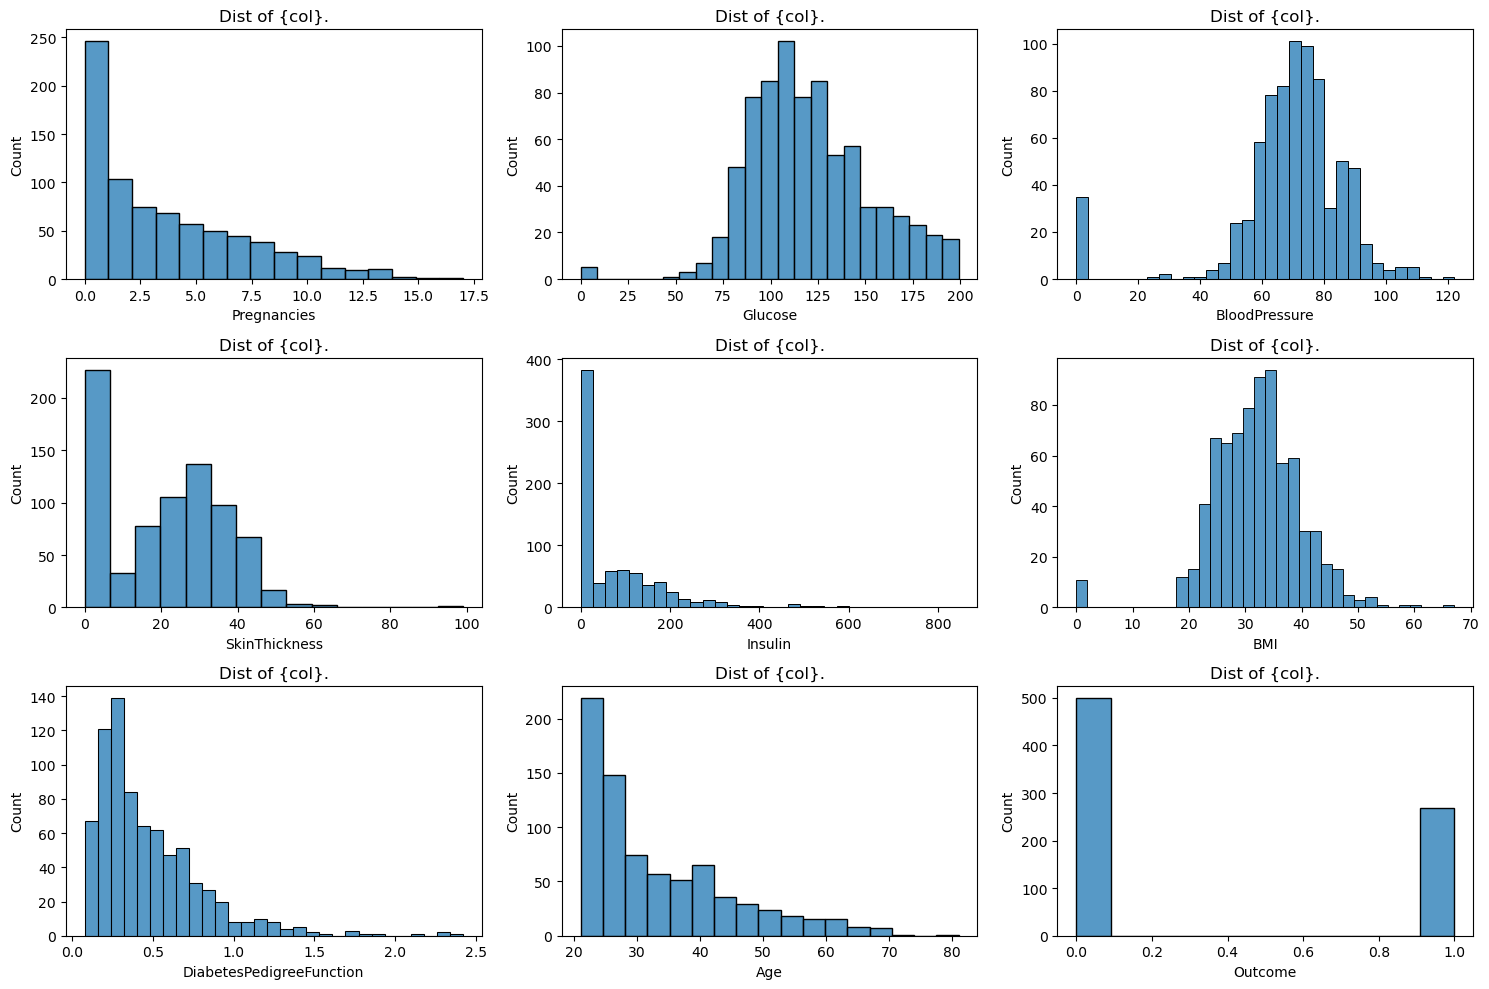

In [41]:
# Data Distribution
fig, axs = plt.subplots(3,3, figsize=(15,10))
for idx, col in enumerate(diabetes_df.columns):
    ax = axs[idx // 3, idx % 3]
    sns.histplot(x=col, data=diabetes_df, ax=ax)
    ax.set_title("Dist of {col}.")

plt.tight_layout()
plt.show()

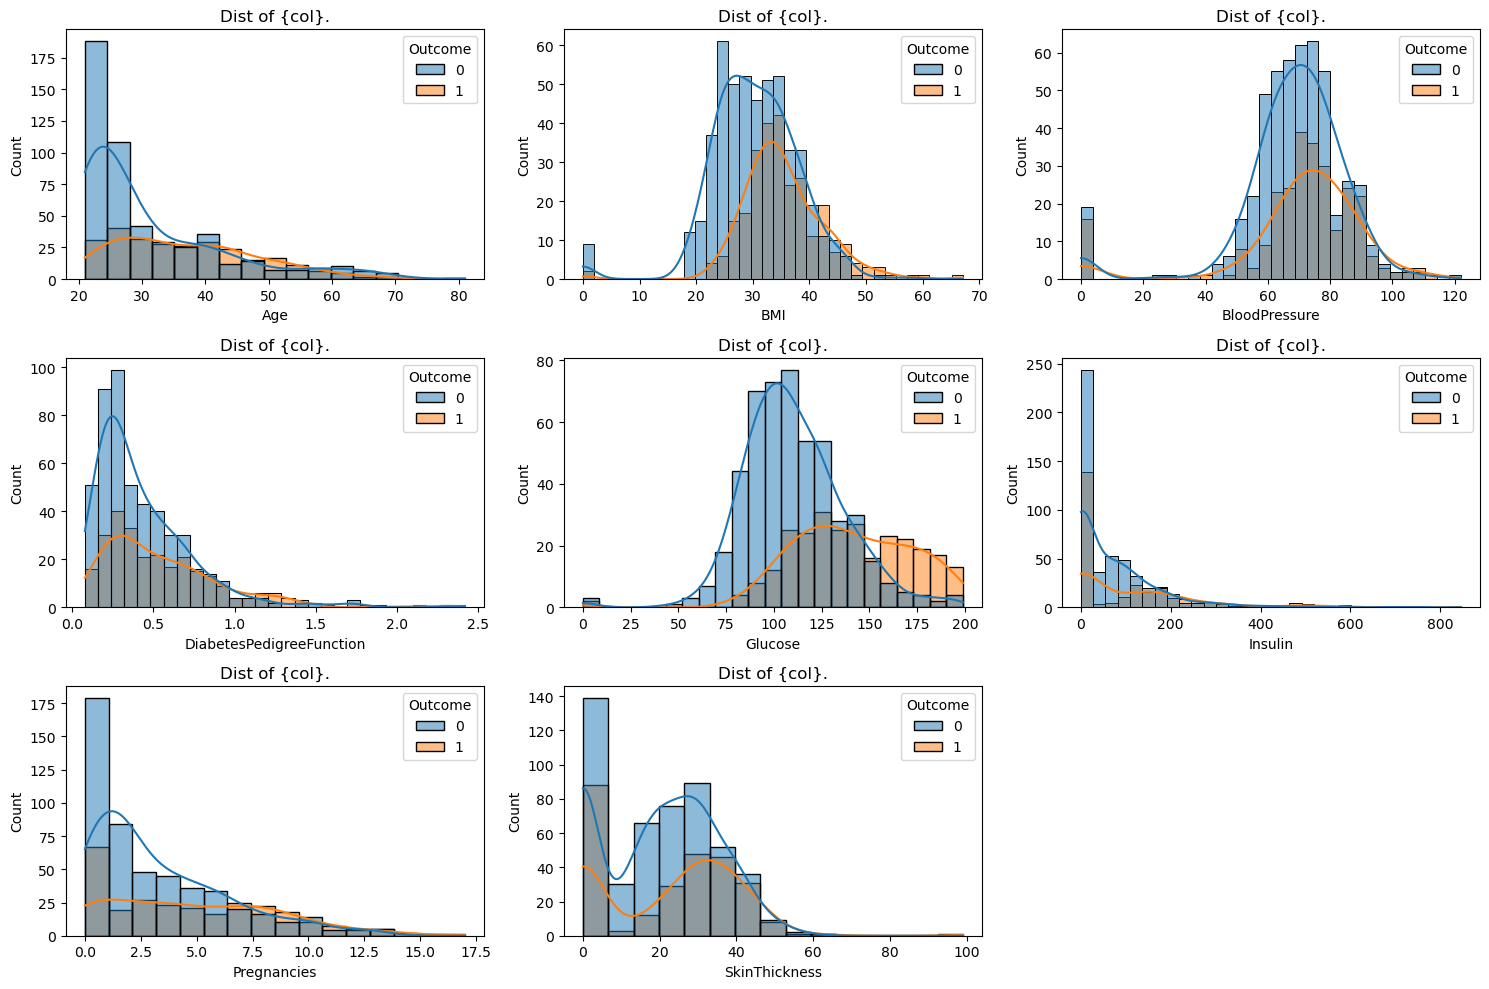

In [42]:
# Data Distribution with Outcome
features_names = diabetes_df.columns.difference(["Outcome"])
fig, axs = plt.subplots(3,3, figsize=(15,10))
for idx, col in enumerate(features_names):
    ax = axs[idx // 3, idx % 3]
    sns.histplot(x=col,hue="Outcome", data=diabetes_df, ax=ax, kde=True)
    ax.set_title("Dist of {col}.")

axs[2,2].axis("off")
plt.tight_layout()
plt.show()

In [43]:
# Check Duplicates
diabetes_df.duplicated().sum()

0

<Axes: >

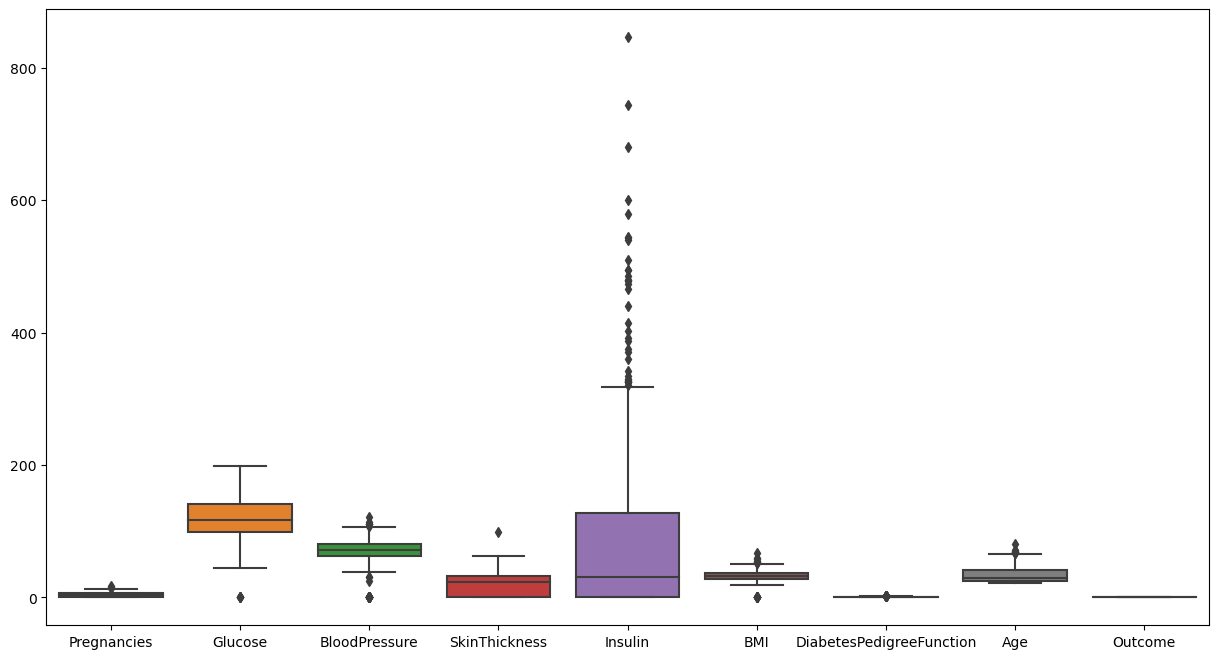

In [ ]:
# Check Outliers 
plt.figure(figsize=(15,8))
sns.boxplot(diabetes_df)

In [ ]:
# Remove Outliers
for col in diabetes_df.columns:
    q1 = diabetes_df[col].quantile(0.25)
    q3 = diabetes_df[col].quantile(0.75)

    IQR = q3-q1
    threshold = 1.5

    lower_bound = q1 - IQR*threshold
    upper_bound = q3 + IQR*threshold

    outliers = ((diabetes_df[col] < lower_bound) | (diabetes_df[col] > upper_bound))
    diabetes_df = diabetes_df[~outliers]

<Axes: >

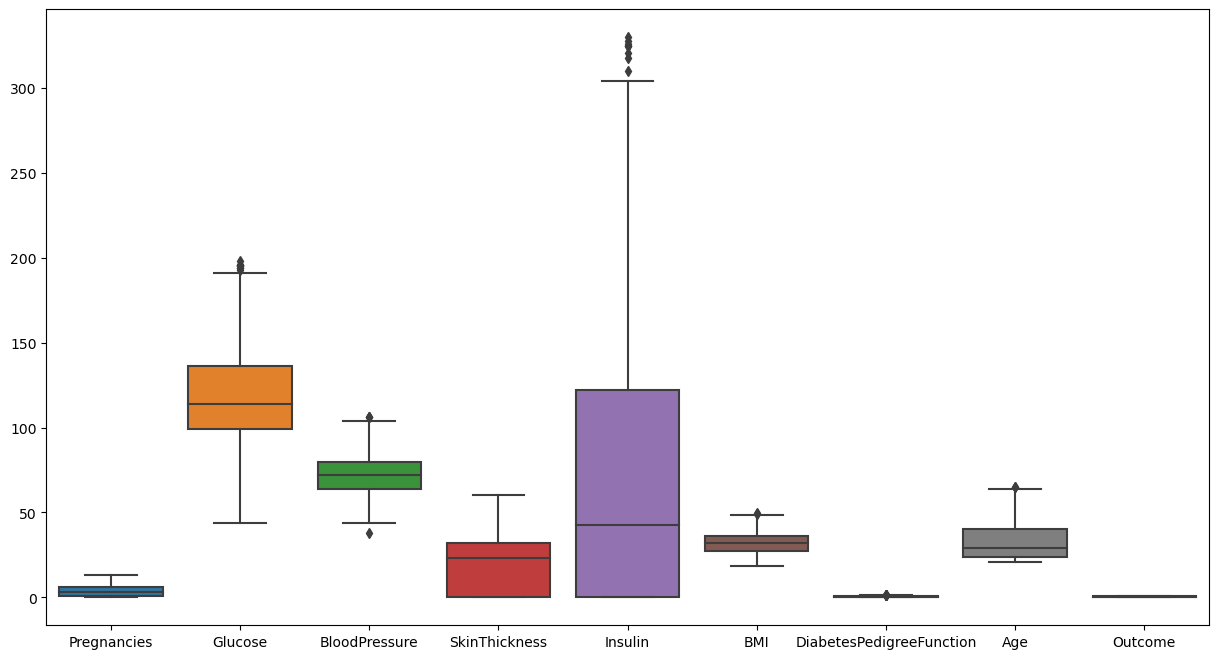

In [ ]:
# Check Outliers
plt.figure(figsize=(15,8))
sns.boxplot(diabetes_df)

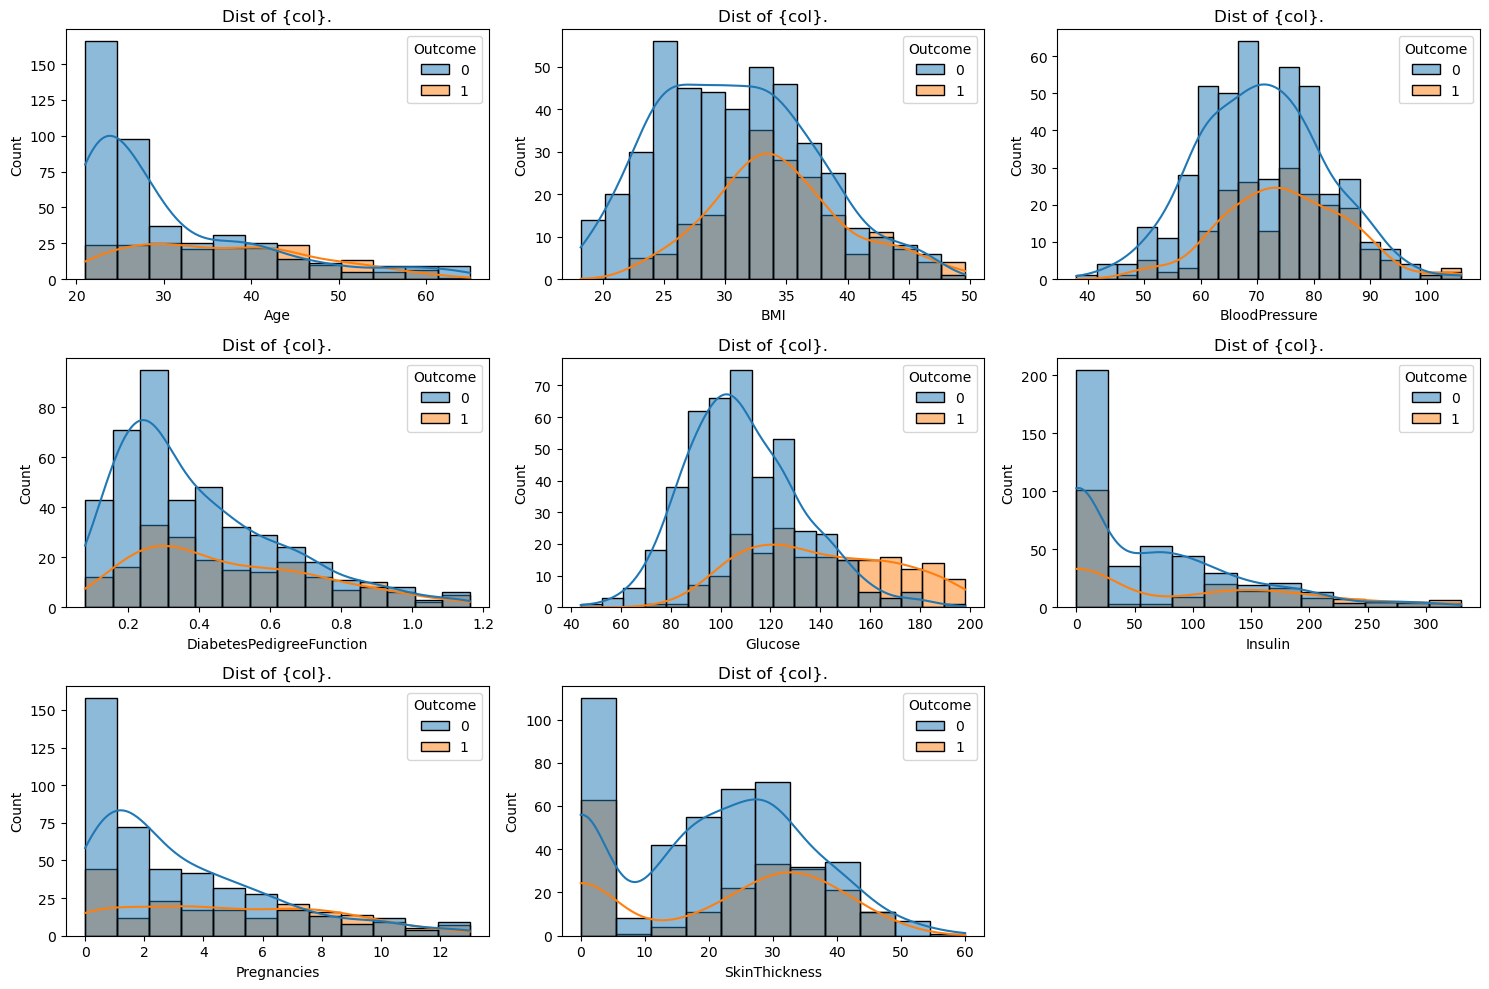

In [47]:
# Data Distribution with Outcome
features_names = diabetes_df.columns.difference(["Outcome"])
fig, axs = plt.subplots(3,3, figsize=(15,10))
for idx, col in enumerate(features_names):
    ax = axs[idx // 3, idx % 3]
    sns.histplot(x=col,hue="Outcome", data=diabetes_df, ax=ax, kde=True)
    ax.set_title("Dist of {col}.")

axs[2,2].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# There is still zero values in Insulin and Skin Thickness

In [49]:
# Replace Zero Values with the Mean
for col in [ "Insulin", "SkinThickness"]:
    diabetes_df[col] = diabetes_df[col].replace(0, diabetes_df[col].median())

for col in [ "Insulin", "SkinThickness"]:
    zero_values = diabetes_df[diabetes_df[col] == 0][col].count()
    print(f"There is {zero_values} zero values in {col}.")

There is 0 zero values in Insulin.
There is 0 zero values in SkinThickness.


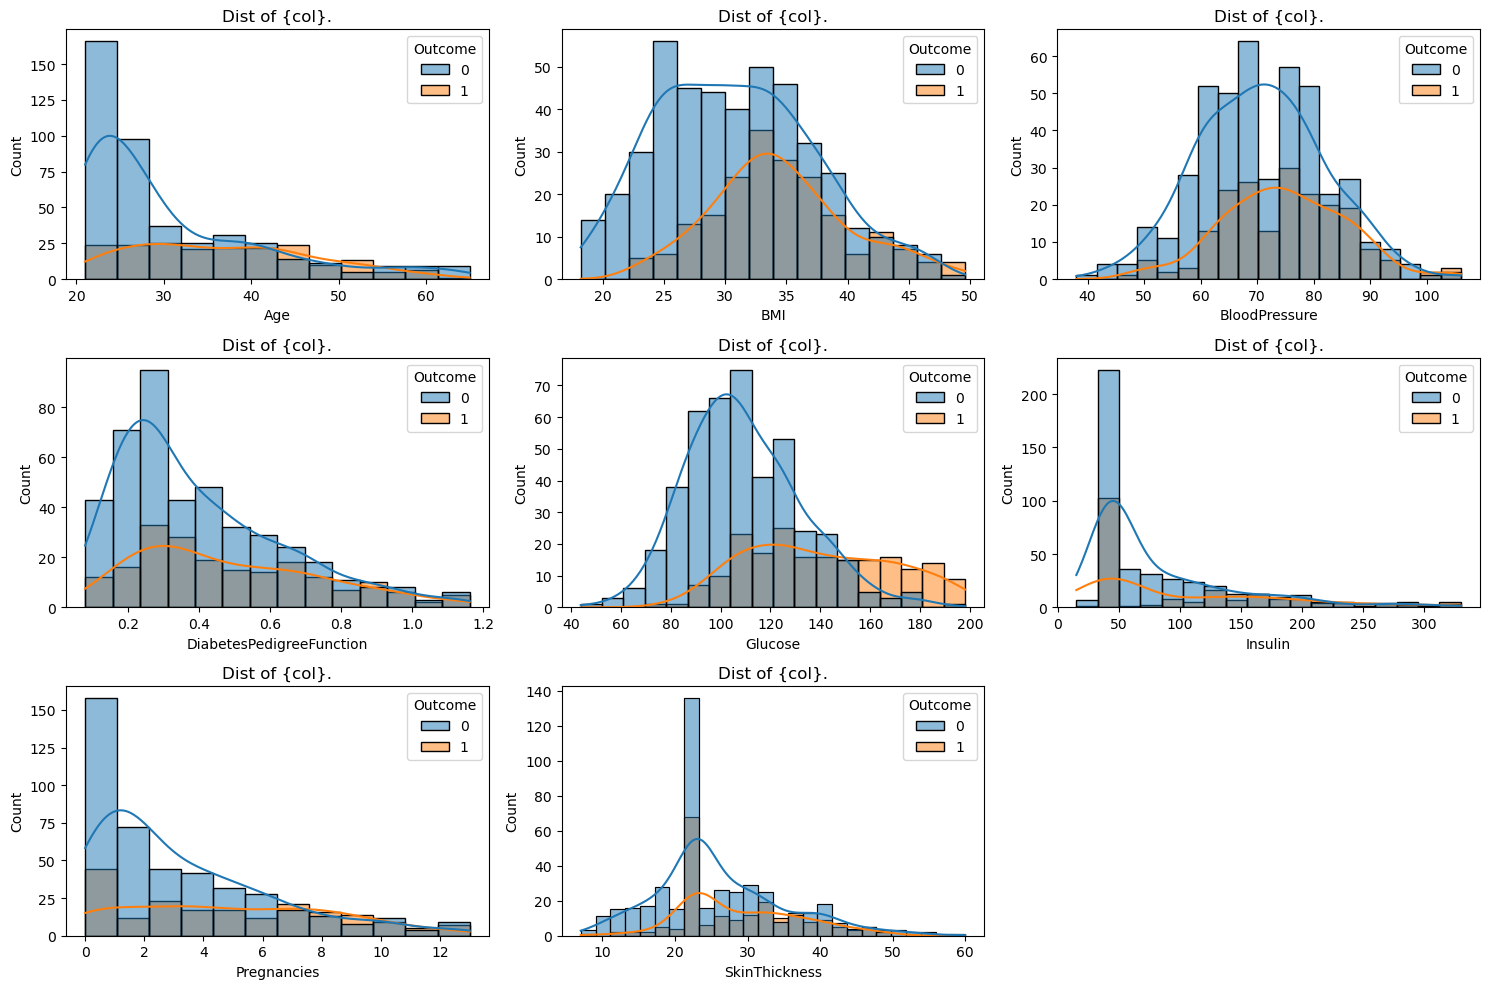

In [50]:
# Data Distribution with Outcome
features_names = diabetes_df.columns.difference(["Outcome"])
fig, axs = plt.subplots(3,3, figsize=(15,10))
for idx, col in enumerate(features_names):
    ax = axs[idx // 3, idx % 3]
    sns.histplot(x=col,hue="Outcome", data=diabetes_df, ax=ax, kde=True)
    ax.set_title("Dist of {col}.")

axs[2,2].axis("off")
plt.tight_layout()
plt.show()

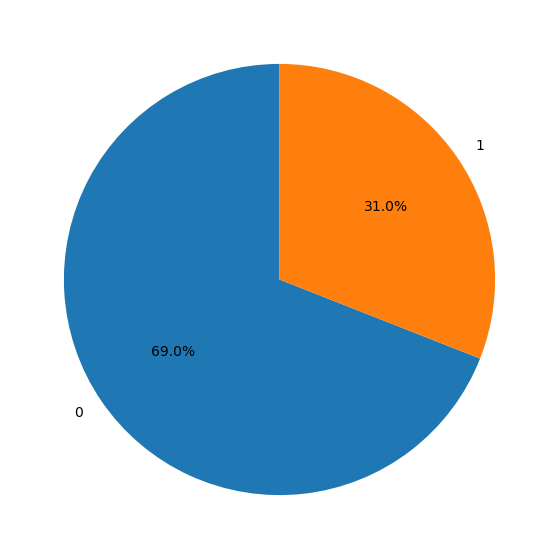

In [51]:
# Check Target
plt.figure(figsize=(7, 7))
plt.pie(diabetes_df["Outcome"].value_counts(), labels=[0,1], autopct='%1.1f%%', startangle=90)
plt.show()

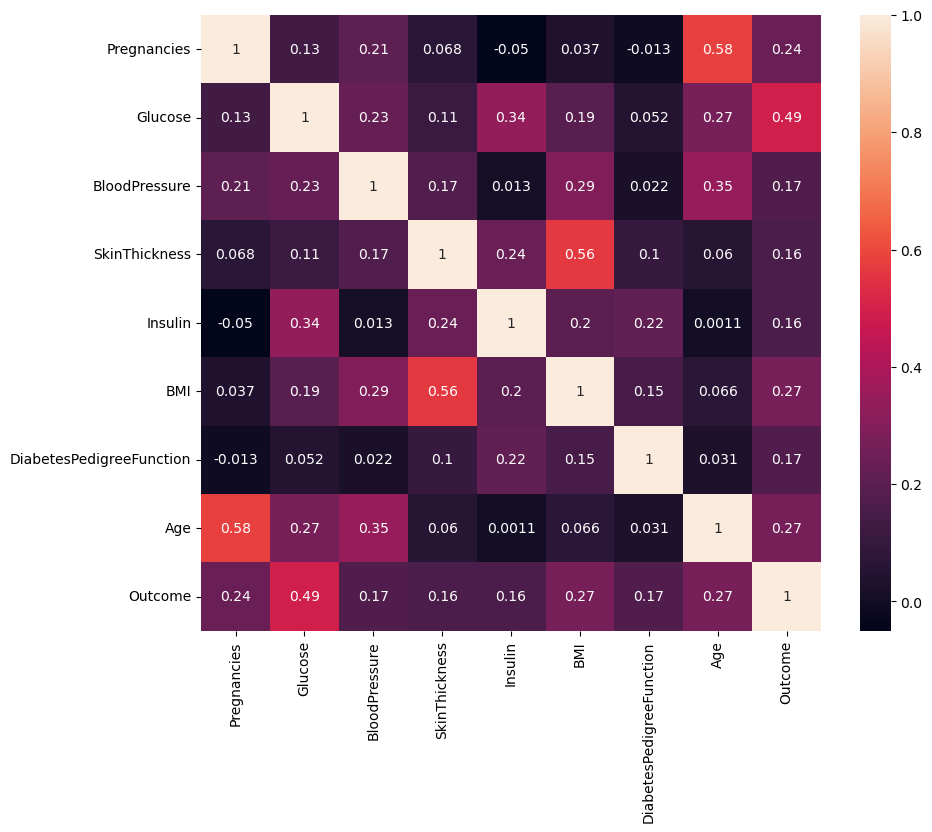

In [52]:
# Correlation
plt.figure(figsize=(10,8))
sns.heatmap(diabetes_df.corr(), annot=True)
plt.show()

In [ ]:
# The correlation analysis shows that glucose has a strong correlation with the target variable.

In [53]:
# Split Data into Features & Target
features = diabetes_df.drop("Outcome", axis=1)
features.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,42.5,33.6,0.627,50
1,1,85,66,29,42.5,26.6,0.351,31
2,8,183,64,23,42.5,23.3,0.672,32
3,1,89,66,23,94.0,28.1,0.167,21
5,5,116,74,23,42.5,25.6,0.201,30


In [54]:
# Target
traget = diabetes_df["Outcome"]
traget

0      1
1      0
2      1
3      0
5      0
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 636, dtype: int64

In [55]:
# Split Data into Train & Test
xtrain, xtest, ytrain, ytest = train_test_split(features, traget, test_size=0.2, random_state=42, stratify=traget)
print(f"Xtrain shape: {xtrain.shape}, Xtest shape: {xtest.shape}, Ytrain shape: {ytrain.shape}, and Ytest shape: {ytest.shape}")

Xtrain shape: (508, 8), Xtest shape: (128, 8), Ytrain shape: (508,), and Ytest shape: (128,)


In [56]:
# Scale Data
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

# Models

                 Model  Recall Score
5            Ada Boost      0.572984
6       Gradient Boost      0.567742
3        Decision Tree      0.566734
4        Random Forest      0.541532
7              XGBoost      0.540927
0  Logistic Regression      0.516129
1                  KNN      0.458468
2                  SVC      0.458468


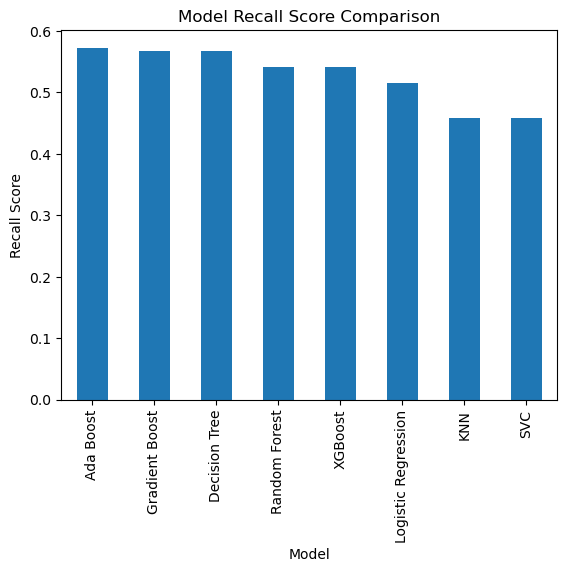

In [61]:
# Try Different Models
models = {
    "Logistic Regression" :  LogisticRegression(random_state=42),
    "KNN" : KNeighborsClassifier(),
    "SVC" : SVC(random_state=42),
    "Decision Tree" : DecisionTreeClassifier(random_state=42),
    "Random Forest" : RandomForestClassifier(random_state=42),
    "Ada Boost" : AdaBoostClassifier(random_state=42),
    "Gradient Boost" : GradientBoostingClassifier(random_state=42),
    "XGBoost" : xgb.XGBClassifier()
}


models_recall = {}
for name, model in models.items():
    cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    recall = cross_val_score(model, xtrain_scaled, ytrain, cv=cv, scoring="recall", n_jobs=-1)
    models_recall[name] = recall.mean()

result = pd.DataFrame(list(models_recall.items()), columns=["Model", "Recall Score"])
print(result.sort_values(by="Recall Score", ascending=False))


# Plot the results
result.sort_values(by="Recall Score", ascending=False).plot(kind='bar', x='Model', y='Recall Score', legend=False)
plt.title("Model Recall Score Comparison")
plt.ylabel("Recall Score")
plt.show()


In [ ]:
#Since we are working with diabetes data, our primary focus is on recall, as the cost of misclassifying a diabetic patient as non-diabetic is much higher. 
# Additionally, we cannot rely on accuracy due to the imbalance in the dataset.

In [62]:
# Evalation Matrix
def model_evaluation(xtrain_pred, ytrain, model_pred, ytest):
    print("Train Data")
    print(f"Recall: {recall_score(xtrain_pred, ytrain)}")
    print(f"Precision: {precision_score(xtrain_pred, ytrain)}")
    print(f"F1 Score: {f1_score(xtrain_pred, ytrain)}")
    print(f"Acurracy: {accuracy_score(xtrain_pred, ytrain)}")
    print("-"*100)
    print(f"Classification Report: ")
    print(classification_report(xtrain_pred, ytrain))
    print("*"*100)
    print("*"*100)
    print("Test Data")
    print(f"Recall: {recall_score(model_pred, ytest)}")
    print(f"Precision: {precision_score(model_pred, ytest)}")
    print(f"F1 Score: {f1_score(model_pred, ytest)}")
    print(f"Acurracy: {accuracy_score(model_pred, ytest)}")
    print("-"*100)
    print(f"Classification Report: ")
    print(classification_report(model_pred, ytest))
    print("-"*100)

    sns.heatmap(confusion_matrix(model_pred, ytest), annot = True, fmt='d')
    plt.show()

Train Data
Recall: 0.8581560283687943
Precision: 0.7707006369426752
F1 Score: 0.8120805369127517
Acurracy: 0.889763779527559
----------------------------------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       367
           1       0.77      0.86      0.81       141

    accuracy                           0.89       508
   macro avg       0.86      0.88      0.87       508
weighted avg       0.90      0.89      0.89       508

****************************************************************************************************
****************************************************************************************************
Test Data
Recall: 0.5789473684210527
Precision: 0.55
F1 Score: 0.5641025641025641
Acurracy: 0.734375
----------------------------------------------------------------------------------------------------
Classification Repo

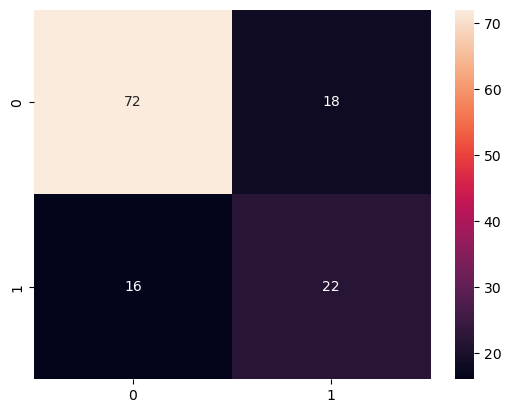

In [ ]:
# AdabetiveBoosting
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(xtrain_scaled, ytrain)
xtrain_pred = ada_model.predict(xtrain_scaled)
ada_pred = ada_model.predict(xtest_scaled)
model_evaluation(xtrain_pred, ytrain, ada_pred, ytest)

In [64]:
# AdabetiveBoosting Tuning
param = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1, 10],
     
}
grid_ada = GridSearchCV(AdaBoostClassifier(random_state=42), param, cv=5, scoring='recall')
grid_ada.fit(xtrain_scaled, ytrain)

print("Best parameters for AdaBoost:", grid_ada.best_params_)
print("Best score for AdaBoost:", grid_ada.best_score_)


Best parameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 50}
Best score for AdaBoost: 0.5860887096774193


Train Data
Recall: 0.7841726618705036
Precision: 0.6942675159235668
F1 Score: 0.7364864864864865
Acurracy: 0.8464566929133859
----------------------------------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       369
           1       0.69      0.78      0.74       139

    accuracy                           0.85       508
   macro avg       0.80      0.83      0.81       508
weighted avg       0.85      0.85      0.85       508

****************************************************************************************************
****************************************************************************************************
Test Data
Recall: 0.5675675675675675
Precision: 0.525
F1 Score: 0.5454545454545454
Acurracy: 0.7265625
----------------------------------------------------------------------------------------------------
Classification R

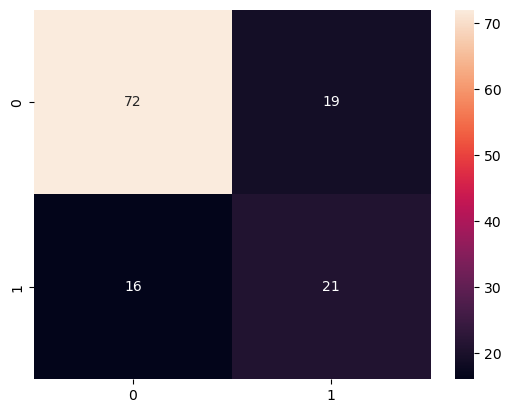

In [65]:
# Tuned AdabetiveBoosting
ada_model1 = AdaBoostClassifier(n_estimators=50,learning_rate=1, random_state=42)
ada_model1.fit(xtrain_scaled, ytrain)
xtrain_pred = ada_model1.predict(xtrain_scaled)
ada_pred1 = ada_model1.predict(xtest_scaled)
model_evaluation(xtrain_pred, ytrain, ada_pred1, ytest)

Train Data
Recall: 0.9712230215827338
Precision: 0.8598726114649682
F1 Score: 0.9121621621621622
Acurracy: 0.9488188976377953
----------------------------------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       369
           1       0.86      0.97      0.91       139

    accuracy                           0.95       508
   macro avg       0.92      0.96      0.94       508
weighted avg       0.95      0.95      0.95       508

****************************************************************************************************
****************************************************************************************************
Test Data
Recall: 0.696969696969697
Precision: 0.575
F1 Score: 0.6301369863013698
Acurracy: 0.7890625
----------------------------------------------------------------------------------------------------
Classification Re

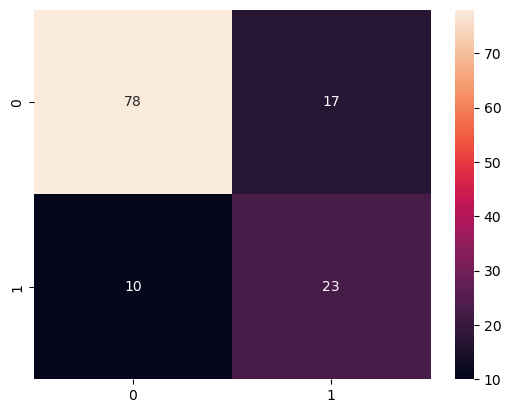

In [67]:
# GradientBoosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(xtrain_scaled, ytrain)
xtrain_pred = gb_model.predict(xtrain_scaled)
y_pred = gb_model.predict(xtest_scaled)
model_evaluation(xtrain_pred, ytrain, y_pred, ytest)

In [60]:
# GradientBoosting Tuning
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5], 
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, scoring='recall', n_jobs=-1)
grid_gb.fit(xtrain_scaled, ytrain)

print("Best parameters for Gradient Boosting:", grid_gb.best_params_)
print("Best score for Gradient Boosting:", grid_gb.best_score_)
best_gb = grid_gb.best_estimator_

Best parameters for Gradient Boosting: {'learning_rate': 0.5, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.6}
Best score for Gradient Boosting: 0.5933467741935483


Train Data
Recall: 1.0
Precision: 1.0
F1 Score: 1.0
Acurracy: 1.0
----------------------------------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       351
           1       1.00      1.00      1.00       157

    accuracy                           1.00       508
   macro avg       1.00      1.00      1.00       508
weighted avg       1.00      1.00      1.00       508

****************************************************************************************************
****************************************************************************************************
Test Data
Recall: 0.6470588235294118
Precision: 0.55
F1 Score: 0.5945945945945946
Acurracy: 0.765625
----------------------------------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support


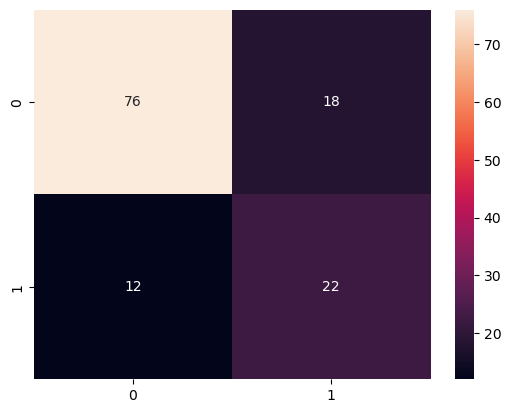

In [68]:
# Tuned Gradient Boost
gb_model1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=3, min_samples_leaf=1, min_samples_split=10,subsample=0.6, random_state=42)
gb_model1.fit(xtrain_scaled, ytrain)
xtrain_pred = gb_model1.predict(xtrain_scaled)
y_pred1 = gb_model1.predict(xtest_scaled)
model_evaluation(xtrain_pred, ytrain, y_pred1, ytest)

Train Data
Recall: 1.0
Precision: 0.8471337579617835
F1 Score: 0.9172413793103448
Acurracy: 0.952755905511811
----------------------------------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       375
           1       0.85      1.00      0.92       133

    accuracy                           0.95       508
   macro avg       0.92      0.97      0.94       508
weighted avg       0.96      0.95      0.95       508

****************************************************************************************************
****************************************************************************************************
Test Data
Recall: 0.53125
Precision: 0.425
F1 Score: 0.4722222222222222
Acurracy: 0.703125
----------------------------------------------------------------------------------------------------
Classification Report: 
              precis

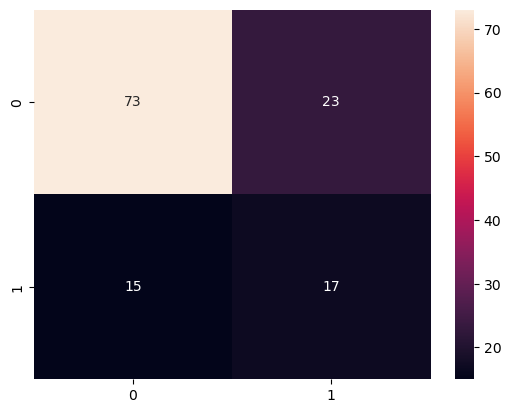

In [69]:
# DecisionTree
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(xtrain_scaled, ytrain)
xtrain_pred = dt_model.predict(xtrain_scaled)
y_pred2 = dt_model.predict(xtest_scaled)
model_evaluation(xtrain_pred, ytrain, y_pred2, ytest)

In [70]:
# Decision Tree Tuning
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [ 5, 10, 15,20,25,30],
    'min_samples_leaf': [1, 2, 4],
    "max_leaf_nodes" : [10,15,20],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring="recall", n_jobs=-1)
grid_search.fit(xtrain, ytrain)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 15, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best Score: 0.6489919354838709


Train Data
Recall: 0.6524064171122995
Precision: 0.7770700636942676
F1 Score: 0.7093023255813954
Acurracy: 0.8031496062992126
----------------------------------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       321
           1       0.78      0.65      0.71       187

    accuracy                           0.80       508
   macro avg       0.80      0.77      0.78       508
weighted avg       0.80      0.80      0.80       508

****************************************************************************************************
****************************************************************************************************
Test Data
Recall: 0.675
Precision: 0.675
F1 Score: 0.675
Acurracy: 0.796875
----------------------------------------------------------------------------------------------------
Classification Report: 
              preci

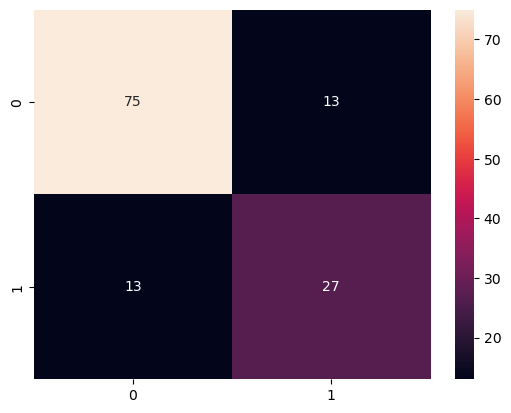

In [71]:
# Tuned Decision Tree
dt_model1 = DecisionTreeClassifier(criterion="entropy",max_depth=5, max_leaf_nodes=15, min_samples_leaf=4, min_samples_split=5, random_state=42)
dt_model1.fit(xtrain_scaled, ytrain)
xtrain_pred = dt_model1.predict(xtrain_scaled)
y_pred3 = dt_model1.predict(xtest_scaled)
model_evaluation(xtrain_pred, ytrain, y_pred3, ytest)

Train Data
Recall: 1.0
Precision: 1.0
F1 Score: 1.0
Acurracy: 1.0
----------------------------------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       351
           1       1.00      1.00      1.00       157

    accuracy                           1.00       508
   macro avg       1.00      1.00      1.00       508
weighted avg       1.00      1.00      1.00       508

****************************************************************************************************
****************************************************************************************************
Test Data
Recall: 0.6538461538461539
Precision: 0.425
F1 Score: 0.5151515151515151
Acurracy: 0.75
----------------------------------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

  

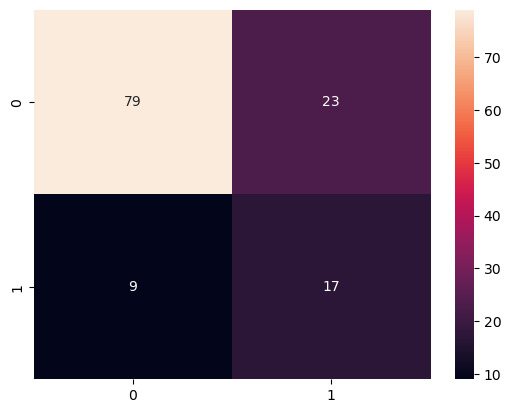

In [75]:
# RandomForest
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
RF_model.fit(xtrain_scaled, ytrain)
xtrain_pred = RF_model.predict(xtrain_scaled)
RF_pred = RF_model.predict(xtest_scaled)
model_evaluation(xtrain_pred, ytrain, RF_pred, ytest)

In [76]:
# RandomForest Tuning
param_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_rf, cv=5, scoring='recall')
grid_rf.fit(xtrain_scaled, ytrain)

print("Best parameters for Random Forest:", grid_rf.best_params_)
print("Best score for Random Forest:", grid_rf.best_score_)

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score for Random Forest: 0.5165322580645161


Train Data
Recall: 1.0
Precision: 1.0
F1 Score: 1.0
Acurracy: 1.0
----------------------------------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       351
           1       1.00      1.00      1.00       157

    accuracy                           1.00       508
   macro avg       1.00      1.00      1.00       508
weighted avg       1.00      1.00      1.00       508

****************************************************************************************************
****************************************************************************************************
Test Data
Recall: 0.6666666666666666
Precision: 0.45
F1 Score: 0.5373134328358209
Acurracy: 0.7578125
----------------------------------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

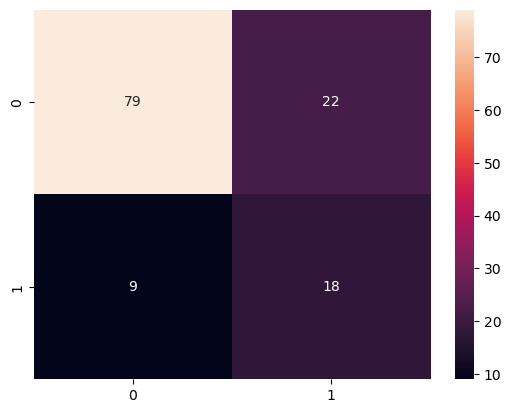

In [77]:
# Tuned RandomForest
RF_model1 = RandomForestClassifier(n_estimators=200, max_depth=None,  min_samples_leaf=1, min_samples_split=2, random_state=42)
RF_model1.fit(xtrain_scaled, ytrain)
xtrain_pred =RF_model1.predict(xtrain_scaled)
RF_pred1 =RF_model1.predict(xtest_scaled)
model_evaluation(xtrain_pred, ytrain, RF_pred1, ytest)

Train Data
Recall: 1.0
Precision: 1.0
F1 Score: 1.0
Acurracy: 1.0
----------------------------------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       351
           1       1.00      1.00      1.00       157

    accuracy                           1.00       508
   macro avg       1.00      1.00      1.00       508
weighted avg       1.00      1.00      1.00       508

****************************************************************************************************
****************************************************************************************************
Test Data
Recall: 0.5945945945945946
Precision: 0.55
F1 Score: 0.5714285714285714
Acurracy: 0.7421875
----------------------------------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

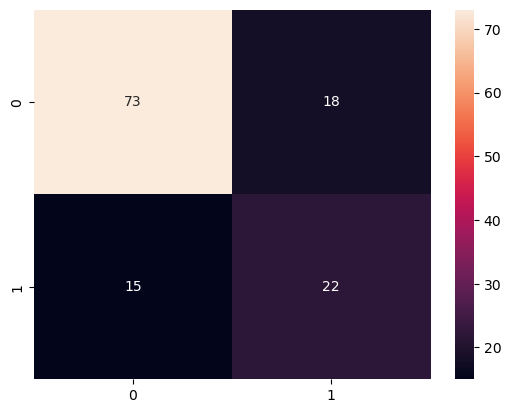

In [72]:
# XGBoost
xgb_model = xgb.XGBClassifier( random_state=42)
xgb_model.fit(xtrain_scaled, ytrain)
xtrain_pred = xgb_model.predict(xtrain_scaled)
y_pred4 = xgb_model.predict(xtest_scaled)
model_evaluation(xtrain_pred, ytrain, y_pred4, ytest)

In [73]:
# XGBoost Tuning
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0], 
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1], 
    'reg_lambda': [1, 10, 100] 
    
}

grid_xgb = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid_xgb, cv=5, scoring='recall', n_jobs=-1)
grid_xgb.fit(xtrain_scaled, ytrain)

print("Best parameters for XGBoost:", grid_xgb.best_params_)
print("Best score for XGBoost:", grid_xgb.best_score_)

Best parameters for XGBoost: {'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best score for XGBoost: 0.6120967741935484


Train Data
Recall: 0.9795918367346939
Precision: 0.9171974522292994
F1 Score: 0.9473684210526315
Acurracy: 0.968503937007874
----------------------------------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       361
           1       0.92      0.98      0.95       147

    accuracy                           0.97       508
   macro avg       0.95      0.97      0.96       508
weighted avg       0.97      0.97      0.97       508

****************************************************************************************************
****************************************************************************************************
Test Data
Recall: 0.6206896551724138
Precision: 0.45
F1 Score: 0.5217391304347826
Acurracy: 0.7421875
----------------------------------------------------------------------------------------------------
Classification Rep

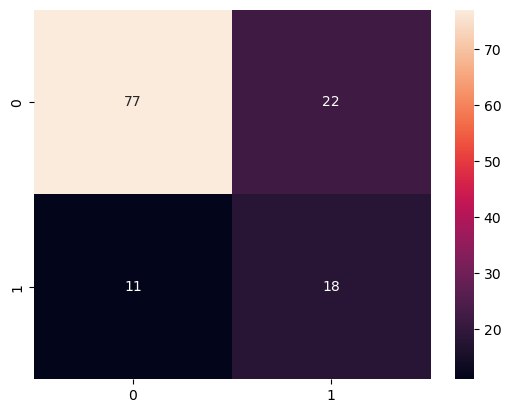

In [74]:
# Tuned XGBoost
xgb_model1 = xgb.XGBClassifier(colsample_bytree= 0.6, gamma= 0.2, learning_rate= 0.2, max_depth= 3, n_estimators= 100, reg_alpha= 0, reg_lambda= 1, subsample= 0.8, random_state=42)
xgb_model1.fit(xtrain_scaled, ytrain)
xtrain_pred = xgb_model1.predict(xtrain_scaled)
y_pred5 = xgb_model1.predict(xtest_scaled)
model_evaluation(xtrain_pred, ytrain, y_pred5, ytest)

Test Data
Recall: 0.675
Precision: 0.675
F1 Score: 0.675
Acurracy: 0.796875
----------------------------------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        88
           1       0.68      0.68      0.68        40

    accuracy                           0.80       128
   macro avg       0.76      0.76      0.76       128
weighted avg       0.80      0.80      0.80       128

----------------------------------------------------------------------------------------------------


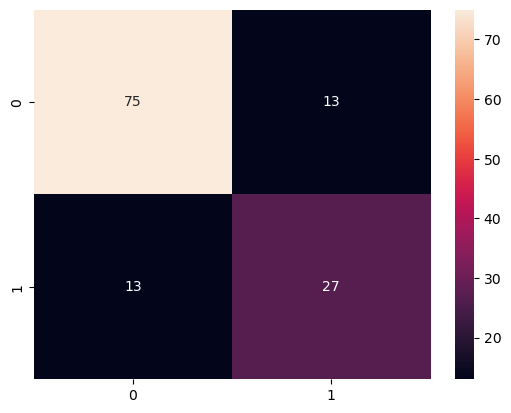

In [79]:
# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ("preprocessor" , scaler),
    ("classifier" , dt_model1)
]) 

pipeline.fit(xtrain, ytrain)
y_pred_pipeline = pipeline.predict(xtest)

print("Test Data")
print(f"Recall: {recall_score(y_pred_pipeline, ytest)}")
print(f"Precision: {precision_score(y_pred_pipeline, ytest)}")
print(f"F1 Score: {f1_score(y_pred_pipeline, ytest)}")
print(f"Acurracy: {accuracy_score(y_pred_pipeline, ytest)}")
print("-"*100)
print(f"Classification Report: ")
print(classification_report(y_pred_pipeline, ytest))
print("-"*100)

sns.heatmap(confusion_matrix(y_pred_pipeline, ytest), annot = True, fmt='d')
plt.show()



In [80]:
# Save the trained pipeline
import joblib

joblib.dump(pipeline, 'diabetes_model_pipeline22.pkl')
print("Model pipeline saved successfully.")

Model pipeline saved successfully.
